File for Testing Methods Locally Instead of Having to Wait for Oscar

In [1]:
# import everything you need up here

from modelPCNNGLSyndeep import *
from pytorchGetData import *
from pytorchUtils import *
import torch

file_path = "scratch/anticancer-synergy-prediction-scratch/"
output_prefix = file_path + "experiments/20240725_pcnnglSyndeep_test/"

# modelPCNNGLSyndeep.py Tests #

- test get_pcnngldeep_hyperparameters

In [2]:
test_params = get_PCNNGLSyndeep_hyperparameters(1)
params = {
    'hidden_sizes': [722, 128, 32],
    'num_epochs': 300,
    'batch_size': 128,
    'learning_rate': 2e-4,
    'loss_fxn': 'MSELoss',
    'optimizer': 'Adam',
    'dropout_rate': 0.8,
}
assert test_params == params, print('params error: ' + str(test_params) + ' vs ' + str(params))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cpu


Get the data and mask

In [3]:
print("Loading data...")
mfp_bc_fn = 'data/ASP_dataset_slices/all_cancer_256_mfp_bc0_comboscore.csv'
all_cancer_data_fn = get_all_cancer_dataset_filename(True, False, False, False, True, False, False, 256, 0)
breast_cancer_indices = get_cancer_type_indices_filename('breast', True, False, False)

data = MorganFingerprintDataset(mfp_bc_fn, True, breast_cancer_indices)
print("Breast cancer BC balanced # of samples: " + str(len(data)))

print("Getting mask...")
mask_fp = output_prefix + '1mask.csv'
mask = get_mask1gl(True, False, False, False, mask_fp, True, False, 256)
hidden_layer_size = mask.shape[0]

output_plot_path = output_prefix + '_'
print(output_prefix)



Loading data...
Using filename:  data/ASP_dataset_slices/all_cancer_256_mfp_bc0_comboscore.csv
Original Dataset shape: (300928, 513)
Reading indices from data/ASP_dataset_slices/breast_comboscore_indices.txt
Filtered Dataset shape: (20989, 513)
Initial dataset size: 20989
Balancing classes
Balanced dataset size: 13316
Breast cancer BC balanced # of samples: 13316
Getting mask...
torch.Size([722, 512])
scratch/anticancer-synergy-prediction-scratch/experiments/20240725_pcnnglSyndeep_test/


- test training the model with k fold cross validation

Fold 1
Actually using BCE Loss
pcnngl_syndeep_model device: cpu
scratch/anticancer-synergy-prediction-scratch/experiments/20240725_pcnnglSyndeep_test/hl722_ne300_bs128_lr0.0002_lfMSELoss_optAdam/
Model is training
Layer: input.weight, Size: torch.Size([722, 512])
Layer: input.bias, Size: torch.Size([722])
Layer: output.weight, Size: torch.Size([1, 32])
Layer: output.bias, Size: torch.Size([1])
Layer: batch_norms.0.weight, Size: torch.Size([512])
Layer: batch_norms.0.bias, Size: torch.Size([512])
Layer: batch_norms.0.running_mean, Size: torch.Size([512])
Layer: batch_norms.0.running_var, Size: torch.Size([512])
Layer: batch_norms.0.num_batches_tracked, Size: torch.Size([])
Layer: batch_norms.1.weight, Size: torch.Size([722])
Layer: batch_norms.1.bias, Size: torch.Size([722])
Layer: batch_norms.1.running_mean, Size: torch.Size([722])
Layer: batch_norms.1.running_var, Size: torch.Size([722])
Layer: batch_norms.1.num_batches_tracked, Size: torch.Size([])
Layer: batch_norms.2.weight, Size: 

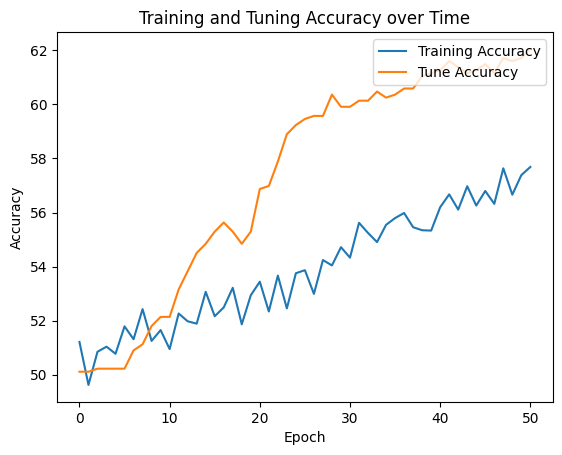

In [4]:
lf=nn.MSELoss()
# K fold cross validation
kf = KFold(n_splits=3, shuffle=True)
all_fold_metrics = pd.DataFrame()
all_fold_metrics = pd.DataFrame(columns=['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score', 'MCC', 'AUC', 'Kappa'])

for fold_index, (train_tune_index, test_index) in enumerate(kf.split(data.x)):
    print(f"Fold {fold_index+1}")

    train_index, tune_index = train_test_split(train_tune_index, test_size=0.1)
    train_subset = Subset(data, train_index)
    train_dataloader = DataLoader(train_subset, batch_size=128, shuffle=True)
    tune_subset = Subset(data, tune_index)
    tune_dataloader = DataLoader(tune_subset, batch_size=128, shuffle=True)
    test_subset = Subset(data, test_index)
    test_dataloader = DataLoader(test_subset, batch_size=128, shuffle=True)

    input_size = train_dataloader.dataset[0][0].shape[0]

    # Create the model
    pcnngl_syndeep_model = PCNNGLSyndeepModel(
        input_size = input_size,
        mask = mask,
        hidden_sizes = params['hidden_sizes'],
        num_epochs = 51, # Short for local testing
        learning_rate = params["learning_rate"],
        loss_fxn = lf,
        device = device,
        binary_classification = True,
        dropout_rate = params["dropout_rate"],
    )

    optimizer = optim.Adam(pcnngl_syndeep_model.parameters(), lr=params["learning_rate"])

    hidden_layers_str = ''
    for hl_idx in range(len(params["hidden_sizes"])):
        hidden_layers_str += str(params["hidden_sizes"][hl_idx]) + ','

    # Check which device pcnngl_syndeep_model is on
    print("pcnngl_syndeep_model device: " + str(next(pcnngl_syndeep_model.parameters()).device))
    
    output_file_prefix = output_prefix +'hl' + hidden_layers_str + '_ne' \
        + str(params["num_epochs"]) + '_bs'  + str(params["batch_size"]) + '_lr' \
        + str(params["learning_rate"]) + '_lf' + params["loss_fxn"] + '_opt' + params["optimizer"] + '/'
    
    print(output_file_prefix)
    
    if not os.path.exists(output_file_prefix):
        os.makedirs(output_file_prefix)
    
    # Train the model
    train_cov_model(
        pcnngl_syndeep_model,
        train_dataloader,
        optimizer,
        output_file_prefix,
        tune_dataloader=tune_dataloader,
        loss_file=output_file_prefix,
    )
    # Print last training loss
    print("Last training loss: " + str(pcnngl_syndeep_model.train_loss_over_time[-1]))

    print_model_params(pcnngl_syndeep_model)

    # Test the model
    fold_metrics = test_cov_model(pcnngl_syndeep_model, test_dataloader, output_file_prefix)
    all_fold_metrics.loc[fold_index] = fold_metrics

all_fold_metrics.to_csv(output_prefix + 'all_fold_metrics.csv')
print(all_fold_metrics.mean())

Test training the model for additional set of epochs (the loading code)

Model is training
Weights loaded from file
Loss loaded from file
Training for 10 more epochs
Layer: input.weight, Size: torch.Size([722, 512])
Layer: input.bias, Size: torch.Size([722])
Layer: output.weight, Size: torch.Size([1, 32])
Layer: output.bias, Size: torch.Size([1])
Layer: batch_norms.0.weight, Size: torch.Size([512])
Layer: batch_norms.0.bias, Size: torch.Size([512])
Layer: batch_norms.0.running_mean, Size: torch.Size([512])
Layer: batch_norms.0.running_var, Size: torch.Size([512])
Layer: batch_norms.0.num_batches_tracked, Size: torch.Size([])
Layer: batch_norms.1.weight, Size: torch.Size([722])
Layer: batch_norms.1.bias, Size: torch.Size([722])
Layer: batch_norms.1.running_mean, Size: torch.Size([722])
Layer: batch_norms.1.running_var, Size: torch.Size([722])
Layer: batch_norms.1.num_batches_tracked, Size: torch.Size([])
Layer: batch_norms.2.weight, Size: torch.Size([128])
Layer: batch_norms.2.bias, Size: torch.Size([128])
Layer: batch_norms.2.running_mean, Size: torch.Size(

PCNNGLSyndeepModel(
  (loss_fxn): BCELoss()
  (sigmoid): Sigmoid()
  (input): Linear(in_features=512, out_features=722, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (batch_norms): ModuleList(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(722, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (ReLU): ReLU()
  (hidden_layers): ModuleList(
    (0): Linear(in_features=722, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=32, bias=True)
  )
  (dropout): Dropout(p=0.8, inplace=False)
)

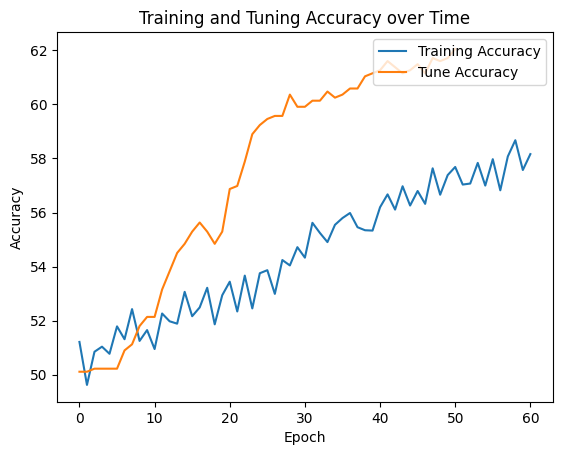

In [5]:
weights_fp = output_prefix + "hl722_ne300_bs128_lr0.0002_lfMSELoss_optAdam/checkpoint/wts_trep50.pth"
loss_fp = output_prefix + "hl722_ne300_bs128_lr0.0002_lfMSELoss_optAdam/checkpoint/loss_trep50.pkl"

# Train the model for 5 more epochs
pcnngl_syndeep_model.num_epochs = 10
train_cov_model(
    model=pcnngl_syndeep_model,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    output_file_prefix=output_prefix,
    checkpoint_weights=weights_fp,
    loss_file=loss_fp,
)